<a href="https://colab.research.google.com/github/axtonisaly1013/GAN_VAE_Comparison/blob/main/VAE_GAN_Comp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
cd /content/drive/My Drive/Colab Notebooks/Machine Learning

/content/drive/My Drive/Colab Notebooks/Machine Learning


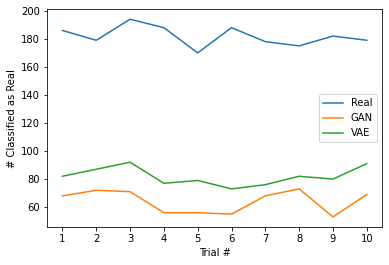

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid

# parameters
batch_size = 256
sample_size = batch_size # fixed sample size
features = 16
features_conv = 32
nz = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()
normalize = transforms.Normalize((0.5,),(0.5,))

# datasets and loaders
val_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=transform
)
val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False
)

class Decoder(nn.Module):
  def __init__(self, features):
    super(Decoder, self).__init__()
    self.features = features
    self.decoder1 = nn.Sequential(
        nn.Linear(self.features, 512), #half the in features?
        nn.LeakyReLU(0.2),
    )
    self.decoder2 = nn.Sequential(
        nn.Linear(512,784),
        nn.Sigmoid(),
    )

  def forward(self, z):
    x = self.decoder1(z)
    reconstruction = self.decoder2(x)
    return reconstruction

class DecoderConv(nn.Module):
  def __init__(self, features):
    super(DecoderConv, self).__init__()
    self.features = features
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512), 
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, bias=False), 
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128), 
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False), 
        nn.Sigmoid(),
    )
    self.fc = nn.Sequential(
        nn.Linear(features,512),
        nn.LeakyReLU(0.2),
        nn.Linear(512,1024),
    )

  def forward(self, z):
    x = self.fc(z)
    x = x.view(-1, 1024, 1, 1)
    reconstruction = self.decoder(x)
    return reconstruction

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

class GeneratorConv(nn.Module):
    def __init__(self, nz):
        super(GeneratorConv, self).__init__()
        self.nz = nz
        self.generator1 = nn.Sequential(
            nn.Linear(self.nz, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1152),
            nn.BatchNorm1d(1152),
        )
        self.generator2 = nn.Sequential(
            nn.ConvTranspose2d(128,64, kernel_size=3, stride=2, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64,32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32,1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
    def forward(self, x):
      x = self.generator1(x)
      x = x.view(-1,128,3,3)
      x = self.generator2(x)
      return x

class DiscriminatorConv(nn.Module):
    def __init__(self):
        super(DiscriminatorConv, self).__init__()
        self.n_input = 784
        self.discrim1 = nn.Sequential(
          nn.Conv2d(1,32, kernel_size=3, stride=2, bias=False),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(0.2),
        )
        self.discrim2 = nn.Sequential(
          nn.Conv2d(32,64, kernel_size=3, stride=3, bias=False),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.2),
        )
        self.discrim3 = nn.Sequential(
          nn.Conv2d(64,128, kernel_size=3, stride=3, bias=False),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2),
        )
        self.discrim4 = nn.Sequential(
          nn.Linear(1152,512),
          nn.LeakyReLU(0.2),
          nn.Linear(512,64),
          nn.LeakyReLU(0.2),
          nn.Linear(64,16),
          nn.LeakyReLU(0.2),
          nn.Linear(16,1),
          nn.Sigmoid(),
        )
    def forward(self, x):
      x = F.pad(x, (15, 14, 15, 14),)
      x = self.discrim1(x)
      x = self.discrim2(x)
      x = self.discrim3(x)
      x = x.view(-1,1152)
      x = self.discrim4(x)
      return x

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

def save_generator_image(image, path):
  save_image(image, path)  

# generate image for debugging
def save_grid_image(image):
  generated_img = make_grid(image)
  save_generator_image(generated_img, f'Plots/GAN_vs_VAE/gen_img.png')

## Prepare models
decoder = DecoderConv(features_conv).to(device)
generator = GeneratorConv(nz).to(device)
discriminator = Discriminator().to(device) # discriminator will be used to evaluate both networks above

decoder.load_state_dict(torch.load('Plots/VAE_Training&Validation/models/decoder_conv.pth', map_location=device))
generator.load_state_dict(torch.load('Plots/GAN_Training/models/generator_conv.pth', map_location=device))
discriminator.load_state_dict(torch.load('Plots/GAN_Training/models/discriminator.pth', map_location=device))

decoder.eval()
generator.eval()
discriminator.eval()

# Store number of correct classifications for each batch
num_correct_VAE = []
num_correct_GAN = []
num_correct_real = []

iterations = 10
examples = enumerate(val_loader)
for i in range(iterations):
  noise_VAE = create_noise(sample_size, features_conv)
  noise_GAN = create_noise(sample_size, nz)
  _,(images, _) = next(examples)
  
  # generate images based on noise
  generated_VAE = decoder(noise_VAE).view(-1,1,28,28) # may need to normalize VAE images
  #normalize VAE image
  for j in range(batch_size):
    generated_VAE[j,:,:,:] = normalize(generated_VAE[j,:,:,:])

  generated_GAN = generator(noise_GAN)

  if generated_VAE.size() != generated_GAN.size() != images.size():
    print("size error")
    print(generated_VAE.size())
    print(generated_GAN.size())

  # evaluate with discriminator
  labels_VAE = torch.round(discriminator(generated_VAE))
  labels_GAN = torch.round(discriminator(generated_GAN))
  labels_real = torch.round(discriminator(images))

  # get number of images classified as real
  # Note: num_correct_real is a measure of how accurate the discriminator really is
  #       the discriminator is a further source of uncertainity, so we can't immediately make conclusions about the generator vs. decoder
  num_correct_VAE.append(torch.sum(labels_VAE).detach().cpu().numpy())
  num_correct_GAN.append(torch.sum(labels_GAN).detach().cpu().numpy())
  num_correct_real.append(torch.sum(labels_real).detach().cpu().numpy())

# # make bar plot
# xlabel = np.linspace(1,iterations,iterations)
# plt.bar(xlabel, num_correct_real, width = 0.1, label = 'Real',color='gold')
# plt.bar(xlabel, num_correct_GAN, width = 0.1, label = 'GAN',color='silver')
# plt.bar(xlabel, num_correct_VAE, width = 0.1, label = 'VAE',color='#CD853F')
# plt.show()

# line plot
xlabel = np.linspace(1,iterations,iterations)
plt.plot(xlabel, num_correct_real, label ='Real')
plt.plot(xlabel, num_correct_GAN, label ='GAN')
plt.plot(xlabel, num_correct_VAE, label ='VAE')
plt.ylabel('# Classified as Real')
plt.xlabel('Trial #')
plt.xticks([1,2,3,4,5,6,7,8,9,10])
plt.legend()
plt.show()